In [13]:
import numpy as np

In [14]:
np.random.seed(42)

In [15]:
X = np.array([
[150, 50], [160, 60], [170, 65], [180, 80], [190, 90], 
[155, 70], [165, 75], [175, 85], [185, 95], [195, 100] 
])

In [16]:
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [17]:
def gini_impurity(y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return 1 - np.sum(probs ** 2)

In [18]:
def split_dataset(X, y, feature_idx, threshold):
    left_mask = X[:, feature_idx] <= threshold
    right_mask = ~left_mask
    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

In [19]:
class DecisionTreeNode:
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

In [20]:
class DecisionTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.root = None
        self.n_classes_ = None  

    def build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1 or depth >= self.max_depth:
            leaf_value = np.bincount(y).argmax()
            return DecisionTreeNode(value=leaf_value)

        best_gini = 1.0
        best_feature, best_threshold = None, None
        for feature_idx in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_idx])
            for t in thresholds:
                _, y_left, _, y_right = split_dataset(X, y, feature_idx, t)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                gini = (len(y_left)/len(y))*gini_impurity(y_left) + (len(y_right)/len(y))*gini_impurity(y_right)
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature_idx
                    best_threshold = t

        if best_feature is None:
            leaf_value = np.bincount(y).argmax()
            return DecisionTreeNode(value=leaf_value)

        X_left, y_left, X_right, y_right = split_dataset(X, y, best_feature, best_threshold)
        left_child = self.build_tree(X_left, y_left, depth+1)
        right_child = self.build_tree(X_right, y_right, depth+1)
        return DecisionTreeNode(best_feature, best_threshold, left_child, right_child)

    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        self.root = self.build_tree(X, y)

    def predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_idx] <= node.threshold:
            return self.predict_one(x, node.left)
        else:
            return self.predict_one(x, node.right)

    def predict(self, X):
        return np.array([self.predict_one(sample, self.root) for sample in X])

    def predict_proba_one(self, x, node):
        if node.value is not None:
            probs = np.zeros(self.n_classes_)
            probs[node.value] = 1.0
            return probs
        if x[node.feature_idx] <= node.threshold:
            return self.predict_proba_one(x, node.left)
        else:
            return self.predict_proba_one(x, node.right)

    def predict_proba(self, X):
        return np.array([self.predict_proba_one(sample, self.root) for sample in X])


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 7
Test size: 3


In [22]:
tree = DecisionTree(max_depth=3)
tree.fit(X_train, y_train)

preds = tree.predict(X_test)
print("Predictions:", preds)
print("Actual:     ", y_test)
print("Accuracy:   ", np.mean(preds == y_test))


Predictions: [0 1 0]
Actual:      [0 0 1]
Accuracy:    0.3333333333333333


In [24]:
tree = DecisionTree(max_depth=3)
tree.fit(X, y)

print("Predictions:", tree.predict(X))
print("Probabilities:\n", tree.predict_proba(X))

Predictions: [0 0 0 0 0 1 1 1 1 1]
Probabilities:
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


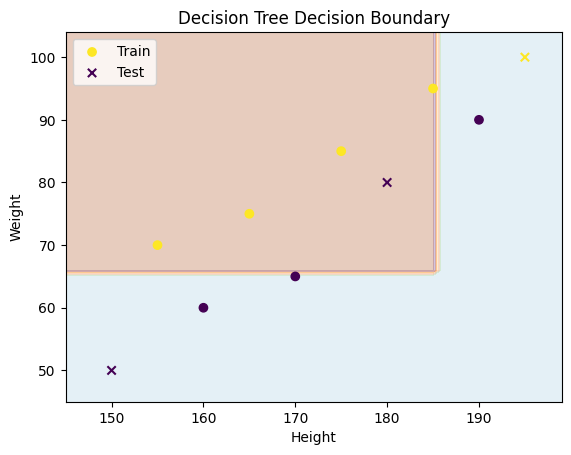

In [23]:
import matplotlib.pyplot as plt

x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = tree.predict(grid_points)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker="o", label="Train")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker="x", label="Test")
plt.xlabel("Height")
plt.ylabel("Weight")
plt.legend()
plt.title("Decision Tree Decision Boundary")
plt.show()